<a href="https://colab.research.google.com/github/GermanM3/GermanM3/blob/master/5%EB%8C%805_%EC%A0%84%EB%9E%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pykrx finance-datareader

In [18]:
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [30]:
# 1. 데이터 불러오기 (2014년 9월 1일 ~ 2024년 8월 31일)
# 코스닥 150 레버리지 (233740), 코스피200 레버리지(122630)
kodex_leverage = fdr.DataReader('233740', '2014-09-01', '2024-08-31')
# KODEX 단기채권PLUS (214980)
kodex_bond = fdr.DataReader('214980', '2014-09-01', '2024-08-31')

# 2. 데이터 병합 및 초기 포트폴리오 설정
df = pd.DataFrame(index=kodex_leverage.index)
df['kodex_leverage_close'] = kodex_leverage['Close']
df['kodex_bond_close'] = kodex_bond['Close']
df = df.dropna()

# 초기 투자금 및 주식 수 계산
initial_investment = 1_000_000 # 100만 원으로 초기 투자금 설정 (단위 변경 가능)
initial_weight = 0.5

leverage_shares = (initial_investment * initial_weight) / df['kodex_leverage_close'].iloc[0]
bond_shares = (initial_investment * initial_weight) / df['kodex_bond_close'].iloc[0]

# 3. 백테스트 로직 (일별 시뮬레이션)
portfolio_history = []
rebalance_count = 0

# 임계치 설정 (주식 비중 N% 초과 또는 N% 미만일 때 리밸런싱)
rebalance_threshold_up = 0.7
rebalance_threshold_down = 0.3

for date, row in df.iterrows():
    # 현재 포트폴리오 가치 계산
    leverage_value = leverage_shares * row['kodex_leverage_close']
    bond_value = bond_shares * row['kodex_bond_close']
    total_value = leverage_value + bond_value

    # 현재 비중 계산
    current_leverage_weight = leverage_value / total_value

    # 리밸런싱 조건 확인
    if current_leverage_weight >= rebalance_threshold_up or current_leverage_weight <= rebalance_threshold_down:
        # 리밸런싱 실행: 비중을 50:50으로 재조정
        rebalance_count += 1
        leverage_shares = (total_value * 0.5) / row['kodex_leverage_close']
        bond_shares = (total_value * 0.5) / row['kodex_bond_close']

    portfolio_history.append(total_value)

# 4. 결과 출력
final_value = portfolio_history[-1]
total_return = (final_value / initial_investment - 1) * 100

print(f"최종 포트폴리오 가치 (초기 100만 원): {final_value:,.0f}원")
print(f"총 수익률: {total_return:.2f}%")
print(f"총 리밸런싱 횟수: {rebalance_count}회")

최종 포트폴리오 가치 (초기 100만 원): 1,489,142원
총 수익률: 48.91%
총 리밸런싱 횟수: 4회


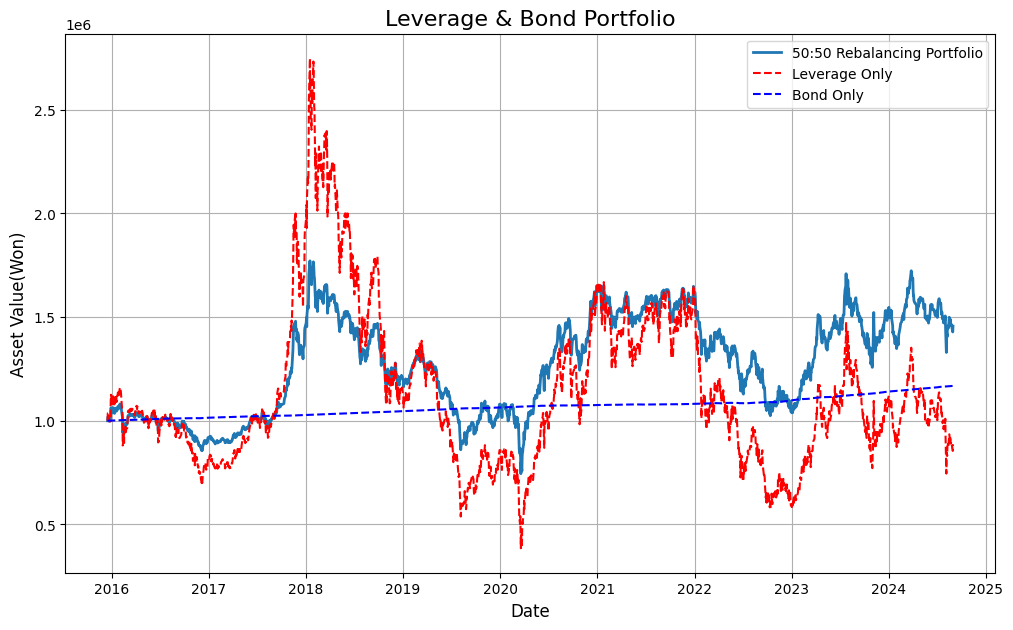

In [26]:
# 5. 시각화
plt.figure(figsize=(12, 7))

# 포트폴리오 가치 그래프
plt.plot(df.index, portfolio_history, label="50:50 Rebalancing Portfolio", linewidth=2)

# 개별 자산 가치 그래프 (비교용)
plt.plot(df.index, (df['kodex_leverage_close'] / df['kodex_leverage_close'].iloc[0]) * initial_investment,
         label='Leverage Only', linestyle='--', color='red')
plt.plot(df.index, (df['kodex_bond_close'] / df['kodex_bond_close'].iloc[0]) * initial_investment,
         label='Bond Only', linestyle='--', color='blue')

plt.title('Leverage & Bond Portfolio', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Asset Value(Won)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()
